In [10]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ff_energy.ffe.utils import read_from_pickle
import jax.numpy as jnp
from ff_energy.ffe.plot import plot_energy_MSE, plot_ff_fit
from ff_energy.ffe.structure import atom_key_pairs
from ff_energy.ffe.potential import LJ, akp_indx
from ff_energy.ffe.ff import FF
from ff_energy.ffe.ff_fit import LJ_bound, load_ff, fit_func, fit_repeat
from ff_energy.ffe.data import pairs_data
from ff_energy.ffe.utils import pickle_output, read_from_pickle, str2int




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
# dataname = "water_cluster/pbe0dz/pbe0_dz.pc"

In [1]:
papermill_job = """papermill templates/ff_template.ipynb out_notebooks/ff/{ffpkl}.ipynb -k pycharmm -p ffpkl {ffpkl}

jupyter nbconvert --to webpdf --no-input out_notebooks/ff/{ffpkl}.ipynb 
mv out_notebooks/ff/{ffpkl}.pdf out_pdfs/ff
"""

In [2]:
pm = papermill_job.format(ffpkl = "ECOL_pbe0dz_FOE.pkl",)

In [3]:
print(pm)


papermill templates/ff_template.ipynb out_notebooks/ff/ECOL_pbe0dz_FOE.pkl.ipynb -k pycharmm -p ffpkl ECOL_pbe0dz_FOE.pkl

jupyter nbconvert --to webpdf --no-input out_notebooks/ff/ECOL_pbe0dz_FOE.pkl.ipynb 
mv out_notebooks/ff/ECOL_pbe0dz_FOE.pkl.pdf out_pdfs/ff



In [6]:
for _ in list(Path("/home/boittier/Documents/phd/ff_energy/pickles/ff/").glob("*_*ff*")):
    n = _.name
    print(n)
    pm = papermill_job.format(ffpkl = n,)
    with open(f"in_scripts/ff/{n}.sh", "w") as f:
        f.write(pm)


kmdcm_pbe0dz_FOE.ff.pkl
pc_pbe0dz_pairs.ff.pkl
mdcm_pbe0dz_FOE.ff.pkl
ECOL_pbe0dz_pairs.ff.pkl
kmdcm_pbe0dz_clusters.ff.pkl
epol_mike_pbe0dz_clusters.ff.pkl
DUMMY_pbe0dz_clusters.ff.pkl
epol_pairs_pbe0dz_FOE.ff.pkl
mdcm_pbe0dz_pairs.ff.pkl
pc_pbe0dz_clusters.ff.pkl
kmdcm_pbe0dz_pairs.ff.pkl
epol_pairs_pbe0dz_clusters.ff.pkl
epol_pairs_pbe0dz_pairs.ff.pkl
epol_mike_pbe0dz_FOE.ff.pkl
ECOL_pbe0dz_FOE.ff.pkl
ECOL_pbe0dz_clusters.ff.pkl
epol_mike_pbe0dz_pairs.ff.pkl
mdcm_pbe0dz_clusters.ff.pkl
DUMMY_pbe0dz_pairs.ff.pkl
pc_pbe0dz_FOE.ff.pkl
DUMMY_pbe0dz_FOE.ff.pkl


# Generating FF objects

In [23]:
pair_eel_epol_path = "/home/boittier/homeb/pair-eel-epol"
files = list(Path(pair_eel_epol_path).glob("*.dat"))


pair_eel_epol = np.zeros((500,190))
pair_eel_epol.shape
for i in range(len(files)):
    fi = files[i]
    IDX = str2int(fi.name.split("-")[0])
    with open(fi) as f:
        for j, line in enumerate(f.readlines()):
            # print(j, line)
            a,b,E = line.split()
            pair_eel_epol[i,j] = float(E)


In [24]:
template_ff = next(read_from_pickle("ff/template.ff.pkl"))

In [25]:
epol = """0 ,  -197.91065793953868
1 ,  -113.95976054505049
2 ,  -160.48478234183463
3 ,  -118.66284499444076
4 ,  -155.77380844422976
5 ,  -150.9995541705951
6 ,  -173.07424212891974
7 ,  -147.23694082382673
8 ,  -140.81293018069294
9 ,  -158.39180721962555
10 ,  -118.69328213099783
11 ,  -160.47184707947005
12 ,  -156.8234077096035
13 ,  -177.00109227393148
14 ,  -173.74116087929457
15 ,  -163.6634882042585
16 ,  -167.55432640034167
17 ,  -178.41306176129993
18 ,  -198.13771741862425
19 ,  -188.25358101682917
20 ,  -193.8544635663619
21 ,  -174.95623313674884
22 ,  -184.7888507989962
23 ,  -141.37639308994395
24 ,  -171.31522554651104
25 ,  -178.14050819168887
26 ,  -117.52904769388255
27 ,  -101.5691221575036
28 ,  -63.32306409695244
29 ,  -124.35656966687516
30 ,  -131.3454553505461
31 ,  -146.44465836118442
32 ,  -125.55640845955148
33 ,  -187.24746843835274
34 ,  -134.03816310896852
35 ,  -151.46381961675218
36 ,  -157.44014713750357
37 ,  -133.19432916720757
38 ,  -118.44675167746216
39 ,  -130.41899497944866
40 ,  -96.71962169598366
41 ,  -140.25823254566004
42 ,  -132.00782359284898
43 ,  -140.3666066008538
44 ,  -94.6945180935851
45 ,  -104.35787694081864
46 ,  -98.55605235390595
47 ,  -103.75579795474555
48 ,  -158.6029659742619
49 ,  -156.2075621992442
50 ,  -137.29242209817735
51 ,  -157.38867195795083
52 ,  -143.9587665773125
53 ,  -160.49270041316544
54 ,  -139.08578473091603
55 ,  -127.32256583556921
56 ,  -133.52154280028606
57 ,  -129.41801720247426
58 ,  -163.74855783048332
59 ,  -162.57353843841216
60 ,  -220.7106384897253
61 ,  -162.31533332880616
62 ,  -146.99186841898728
63 ,  -122.25799053811981
64 ,  -104.13337147993839
65 ,  -222.82863109624273
66 ,  -148.6798506977639
67 ,  -139.0026072939859
68 ,  -191.54216558892787
69 ,  -111.74711484742922
70 ,  -114.34141607914923
71 ,  -134.26584566451405
72 ,  -111.61147067502075
73 ,  -68.74539274039216
74 ,  -125.23712106570335
75 ,  -119.72667684459184
76 ,  -105.68142509224414
77 ,  -114.0079285241558
78 ,  -166.62518541586059
79 ,  -138.31552392610888
80 ,  -113.6338729704916
81 ,  -103.55039008081674
82 ,  -74.05014723602753
83 ,  -161.0464137539695
84 ,  -169.16727957022107
85 ,  -116.72034605589631
86 ,  -154.6530140654059
87 ,  -141.92759194648076
88 ,  -150.50258823950628
89 ,  -89.75511878476112
90 ,  -152.1632764230551
91 ,  -127.14255104592746
92 ,  -113.4417478133013
93 ,  -149.76383676877262
94 ,  -132.40553107818423
95 ,  -139.87832074936503
96 ,  -184.42649320021619
97 ,  -149.53282071826797
98 ,  -125.01340104365532
99 ,  -121.01651200622626
100 ,  -131.23403732702712
101 ,  -135.33980489815647
102 ,  -122.25457535247075
103 ,  -121.73708932333814
104 ,  -124.52892877852035
105 ,  -142.63868841911435
106 ,  -113.46730455520016
107 ,  -138.4834628053034
108 ,  -116.6604899368394
109 ,  -122.83959012347547
110 ,  -132.83305771413333
111 ,  -118.04514728433566
112 ,  -146.26036074190165
113 ,  -152.04025326197026
114 ,  -99.29683014669214
115 ,  -93.61570550553861
116 ,  -97.759998903551
117 ,  -92.54654182313033
118 ,  -148.05985471245475
119 ,  -171.74064617484493
120 ,  -158.37824648524085
121 ,  -163.9310858529523
122 ,  -133.1519393580275
123 ,  -104.48857602519008
124 ,  -100.09295420076245
125 ,  -134.1732050853578
126 ,  -181.36676117532465
127 ,  -136.01644247482957
128 ,  -163.06759485102845
129 ,  -103.55941073931717
130 ,  -176.19926601928893
131 ,  -112.50942640698553
132 ,  -164.52351684809835
133 ,  -98.38262119107118
134 ,  -192.03803808751383
135 ,  -117.40146061983016
136 ,  -203.52585087896162
137 ,  -150.67198570743201
138 ,  -168.57885299017664
139 ,  -191.37468962908642
140 ,  -182.49952656105646
141 ,  -177.96610283612003
142 ,  -152.49099413924128
143 ,  -149.0694070084556
144 ,  -160.03356428336957
145 ,  -161.00494295899097
146 ,  -175.84450793580197
147 ,  -172.60024775475978
148 ,  -140.46179406155252
149 ,  -180.09731736283342
150 ,  -187.61653019298308
151 ,  -212.6295443454816
152 ,  -154.54364412162647
153 ,  -161.94330866961997
154 ,  -162.7163161628733
155 ,  -152.84155970078672
156 ,  -116.71036513154354
157 ,  -129.36509726253942
158 ,  -131.9660601103589
159 ,  -136.63475265426
160 ,  -116.11973810721798
161 ,  -120.38774694113881
162 ,  -119.5202555186028
163 ,  -141.01055881472715
164 ,  -144.46128774131853
165 ,  -108.45322350362545
166 ,  -146.38659946548148
167 ,  -121.06569186828209
168 ,  -164.8425426551654
169 ,  -128.3106393840857
170 ,  -140.87884225104986
171 ,  -109.04465637034687
172 ,  -149.31692824135405
173 ,  -140.97284721324667
174 ,  -185.84721412962716
175 ,  -87.16690444094921
176 ,  -127.11971131891337
177 ,  -121.78875579526465
178 ,  -94.62579184077792
179 ,  -154.06856694334144
180 ,  -126.58305521132652
181 ,  -150.22552911952684
182 ,  -168.9872567263872
183 ,  -146.08914023728988
184 ,  -130.00968245670916
185 ,  -123.92680806290872
186 ,  -171.00487635718318
187 ,  -162.99128642290083
188 ,  -154.30408030724868
189 ,  -129.72560135969874
190 ,  -174.91585469743524
191 ,  -168.12091414916665
192 ,  -173.1714795800777
193 ,  -136.90591807673655
194 ,  -117.24349630702164
195 ,  -139.76560238970288
196 ,  -183.22006543282674
197 ,  -225.18751748735028
198 ,  -175.77731894697334
199 ,  -218.8560233769574
200 ,  -166.59707730045
201 ,  -154.71269723938303
202 ,  -162.61343196658177
203 ,  -166.94470006504375
204 ,  -201.97669876824668
205 ,  -172.60312365739762
206 ,  -135.73204577207756
207 ,  -218.2251354879628
208 ,  -145.16193060664017
209 ,  -166.50854141806855
210 ,  -92.66225206815697
211 ,  -95.03843853880736
212 ,  -168.58600880897836
213 ,  -178.42290507292356
214 ,  -154.38200313859699
215 ,  -127.3921018102241
216 ,  -154.9799789440253
217 ,  -143.91576674004492
218 ,  -126.51182445596
219 ,  -147.31188922237382
220 ,  -106.25931199910556
221 ,  -142.32985958471508
222 ,  -134.8855906905134
223 ,  -92.19348208733852
224 ,  -122.75770761171715
225 ,  -116.47760240592594
226 ,  -136.68437207076178
227 ,  -96.41595648459817
228 ,  -110.02308776374457
229 ,  -109.08382077012801
230 ,  -147.28641607322268
231 ,  -131.8719714683869
232 ,  -163.90524036234868
233 ,  -135.4888825472675
234 ,  -182.2260314401159
235 ,  -182.318235939479
236 ,  -176.6586109856553
237 ,  -210.6920690681493
238 ,  -184.13776271166273
239 ,  -194.52038982551454
240 ,  -129.56962967308854
241 ,  -187.40306469387977
242 ,  -178.25452476092588
243 ,  -177.08518455402404
244 ,  -164.56639157545314
245 ,  -151.70448425218103
246 ,  -213.59999280136256
247 ,  -188.89162388807958
248 ,  -152.1115179005135
249 ,  -148.91438382750053
250 ,  -135.94602189890406
251 ,  -129.2290004182587
252 ,  -181.35211175591652
253 ,  -150.2589028964324
254 ,  -176.47573952190288
255 ,  -114.4861089496999
256 ,  -139.45749085410586
257 ,  -85.59112786458763
258 ,  -111.75937953590896
259 ,  -120.77943530585628
260 ,  -145.09305898578808
261 ,  -127.37196837199764
262 ,  -132.24922436328137
263 ,  -172.95483097197533
264 ,  -171.6842750465584
265 ,  -141.74045229473543
266 ,  -128.6187340094404
267 ,  -115.22677126772948
268 ,  -87.49417582960405
269 ,  -119.00553833026392
270 ,  -145.16487233643483
271 ,  -146.89606594628503
272 ,  -165.8117198517518
273 ,  -165.72081372915596
274 ,  -192.78226672266567
275 ,  -186.8984327704939
276 ,  -146.8536188822844
277 ,  -153.3096171660629
278 ,  -116.03441374016784
279 ,  -179.87700384667718
280 ,  -155.86022229319852
281 ,  -112.68389636873628
282 ,  -158.68828839172923
283 ,  -153.15095405538023
284 ,  -137.08986862090384
285 ,  -164.72905065241426
286 ,  -172.03191175685788
287 ,  -130.56491035884576
288 ,  -157.85752914137015
289 ,  -154.5103234341981
290 ,  -115.23777602651654
291 ,  -150.6393340220742
292 ,  -101.66707383279366
293 ,  -157.072003313081
294 ,  -172.64148560018393
295 ,  -122.95268390362006
296 ,  -137.1125311856307
297 ,  -115.27341295705114
298 ,  -147.51364068946347
299 ,  -144.28838249935387
300 ,  -182.95079217869116
301 ,  -186.46028919370892
302 ,  -137.68904142665755
303 ,  -155.547663597629
304 ,  -135.1218083439805
305 ,  -169.60661693494816
306 ,  -150.65642705608224
307 ,  -151.21653451844318
308 ,  -162.8781011200412
309 ,  -150.40664423433495
310 ,  -146.70664618073587
311 ,  -144.5989112202992
312 ,  -117.4091005965672
313 ,  -174.50071438273164
314 ,  -173.04620244688482
315 ,  -136.35113255166135
316 ,  -153.6376103643359
317 ,  -154.26892049663815
318 ,  -170.01896492852148
319 ,  -141.6948895126982
320 ,  -129.7262870826985
321 ,  -125.18534684805631
322 ,  -148.19078947284842
323 ,  -113.81954853803276
324 ,  -135.5309002309315
325 ,  -144.54521767599255
326 ,  -198.347633419013
327 ,  -221.69789553692615
328 ,  -153.9779542096772
329 ,  -128.5921658709472
330 ,  -127.45796992908281
331 ,  -162.14254046008992
332 ,  -190.326381123613
333 ,  -181.9829186951046
334 ,  -159.68036428404403
335 ,  -164.29356678331757
336 ,  -165.70373801832085
337 ,  -93.24609645938135
338 ,  -133.43030278529997
339 ,  -132.3356772099623
340 ,  -79.777396965206
341 ,  -108.11844161579167
342 ,  -152.77540131413681
343 ,  -92.19029200598075
344 ,  -224.08284340817588
345 ,  -145.73178570714322
346 ,  -176.8137443814284
347 ,  -136.37914194933904
348 ,  -145.89992399826727
349 ,  -133.70047283531107
350 ,  -190.00703133341156
351 ,  -129.20949851604306
352 ,  -210.02878233716982
353 ,  -158.20855604061086
354 ,  -173.73164063821497
355 ,  -127.59354427806704
356 ,  -118.43041095261565
357 ,  -130.59115386817282
358 ,  -119.98755794469713
359 ,  -138.08287575396685
360 ,  -145.54611259544504
361 ,  -183.51568992824684
362 ,  -159.6846957227436
363 ,  -139.65678192416138
364 ,  -160.71230532928982
365 ,  -161.46381162021714
366 ,  -151.1265198420425
367 ,  -158.45731309016028
368 ,  -136.11102729281572
369 ,  -163.4007809673061
370 ,  -186.8974025328093
371 ,  -144.56136557125194
372 ,  -154.82524093265778
373 ,  -135.75022395986264
374 ,  -171.36304630929985
375 ,  -151.07585008987124
376 ,  -147.1596234922252
377 ,  -159.57705818539142
378 ,  -143.86093696685725
379 ,  -146.08066993212094
380 ,  -169.5226108717697
381 ,  -151.2936853180194
382 ,  -172.52198500342178
383 ,  -142.86226075130875
384 ,  -126.23424385181063
385 ,  -145.6186316739386
386 ,  -130.9282196913256
387 ,  -115.88637024893355
388 ,  -167.12805248949857
389 ,  -183.96276417630537
390 ,  -185.64589801962302
391 ,  -174.56399702263144
392 ,  -149.5067572086489
393 ,  -178.1888065466192
394 ,  -203.42501518068133
395 ,  -171.8512163911251
396 ,  -188.1692223647881
397 ,  -163.06443294479655
398 ,  -154.9605484335649
399 ,  -165.43211942530488
400 ,  -134.70896639165218
401 ,  -132.93053582445026
402 ,  -156.22766220581585
403 ,  -189.64617366341614
404 ,  -153.60101898447243
405 ,  -137.97833722336344
406 ,  -173.0666789717097
407 ,  -138.0286098201197
408 ,  -128.0769781876476
409 ,  -164.4485752883095
410 ,  -187.35269959266455
411 ,  -169.4455468314607
412 ,  -169.12828241470055
413 ,  -193.7461669574241
414 ,  -210.55900661036668
415 ,  -167.6866453905028
416 ,  -176.4117992922177
417 ,  -224.88894431205094
418 ,  -150.3837476574898
419 ,  -181.86284382043837
420 ,  -110.15165030287531
421 ,  -129.94622762695093
422 ,  -171.36603113943565
423 ,  -150.31053006001036
424 ,  -146.9040494907478
425 ,  -172.38834874944396
426 ,  -138.13516572924362
427 ,  -188.63251158512765
428 ,  -135.83725630553306
429 ,  -138.5639441727243
430 ,  -141.16270563236534
431 ,  -129.16516936630873
432 ,  -133.02327636904528
433 ,  -167.88587839249647
434 ,  -207.4458341999899
435 ,  -134.7782213317515
436 ,  -201.75974102341593
437 ,  -165.526856874407
438 ,  -165.34550067988462
439 ,  -146.26241790101832
440 ,  -157.3818750086686
441 ,  -173.419303887717
442 ,  -144.85829830210997
443 ,  -125.2272886359566
444 ,  -145.4509004028357
445 ,  -126.29849746737422
446 ,  -134.53774903375447
447 ,  -178.05464801001472
448 ,  -148.0808633603926
449 ,  -192.45222092695712
450 ,  -196.5152445133216
451 ,  -120.87186996251448
452 ,  -148.07570325389446
453 ,  -129.71429157094838
454 ,  -100.02675798486555
455 ,  -109.82438281173248
456 ,  -143.79180766832258
457 ,  -110.90499964204433
458 ,  -121.0903204044003
459 ,  -80.91582382197416
460 ,  -128.0610416314565
461 ,  -108.26132659009966
462 ,  -133.53743335683583
463 ,  -140.61833835469196
464 ,  -147.08798713251397
465 ,  -120.4668444702327
466 ,  -124.8655282550199
467 ,  -124.55768281149106
468 ,  -182.32435106558088
469 ,  -184.1076853517829
470 ,  -115.19343752392219
471 ,  -144.69687203558945
472 ,  -164.4978536092102
473 ,  -176.067067800297
474 ,  -136.8737724386799
475 ,  -188.70717124123934
476 ,  -95.01626104656552
477 ,  -177.39960493781564
478 ,  -186.09571371022167
479 ,  -184.84918725081738
480 ,  -168.4735024191577
481 ,  -167.77741720196985
482 ,  -170.25925082611033
483 ,  -154.64134931099312
484 ,  -149.36906767363558
485 ,  -153.58562733913467
486 ,  -168.3041350722371
487 ,  -177.77162454707175
488 ,  -122.04998839818906
489 ,  -201.6326593357404
490 ,  -169.58193634637348
491 ,  -150.81916099895923
492 ,  -159.3010712255848
493 ,  -156.25635440123125
494 ,  -157.79941150176913
495 ,  -175.80632021987057
496 ,  -138.41012605502584
497 ,  -178.9292131789199
498 ,  -171.90337621167242
499 ,  -176.12406452564676"""
epol_data = [float(_.split(",")[1]) for _ in epol.split("\n")]
# epol_data

In [26]:
first_order_energy = """7.640822312169947
-5.902675987018749
-6.037152396045854
-4.570214471819514
-12.251941741814242
7.304728365422202
18.29076174429756
10.72935496010793
-2.5118579710916125
6.600795332866156
-3.238907636758919
29.00248067643463
5.73452873777264
10.959869559712917
-0.7428700581068808
8.695036150715646
19.58156993384515
20.074269536597726
15.936627148729807
36.509910978498056
35.4923349701155
21.096131183199702
48.09945817875741
14.178987932788939
8.336955652693359
10.064278255228833
0.1874171239341945
4.413197483640748
5.944498928822997
17.18684796308074
1.9025981080862557
16.326083308598513
2.0234844816148367
11.735260735277775
-12.48761892471163
-9.228796270679437
18.919773095507832
-6.771217931295426
23.691126629232592
5.575962867757317
3.4832886897054003
9.973438101808876
20.33059937392939
-2.443072077632701
7.363092393697632
2.8630759001468533
3.3757477485149736
11.440206409802352
13.574728378933035
13.72467377454131
-0.1313537965699332
-2.6486086001035387
12.50044314738896
18.02432636889657
4.058545760077274
-0.5850456534496682
-11.51519090517341
14.05312421642213
12.884562213766744
29.16528223517449
9.919662861842562
31.19547849553594
5.057662134146705
30.5876405059762
8.483134862399808
1.465110930606622
-7.06680746005341
11.837785742482133
23.662281022812472
4.7754763337995305
-1.1696891984142397
14.518528035818642
12.157843182756185
1.595977214421474
4.82130234611716
2.141990460569782
-6.550232941402386
3.1470532401679634
2.7783156860322227
-4.137235949668557
-6.929295661775147
-6.45097920375123
-15.466213733564588
2.048705844410227
4.345043240600023
9.4438848679684
-16.084612832772162
13.701204292907246
25.902064065560833
-1.6191744199470748
1.8344419827510472
24.40252476543653
9.85624267605908
8.186622267939878
-15.070479906132398
-10.511833508569683
15.267871983314114
-2.7984552259293114
-9.681613253741352
-9.068808903552553
21.239707357940762
4.651076910981265
15.68152453190058
-1.1111455137892656
32.88285798627112
35.55652943998168
-6.997763031940237
0.11865927970392581
-12.743374340038718
-16.17069345213969
4.839678584690149
2.95718336984681
18.182011341279104
32.87566930068913
8.197818856755884
0.9693463832978875
16.2818628416376
17.359236925651093
25.85806918855284
10.541726051782542
11.473967925473875
15.236831976557315
27.555919364999887
9.89243390820711
23.290460953934215
0.499466790200951
20.17413710365971
7.8197796041614565
-3.928250572478793
16.685653513980608
9.842055314640122
-5.435474415993057
3.517820724674471
-2.8747051564917507
-8.11849764354477
-2.6793061124642352
8.0307805421764
0.5536926442968225
15.078950531154144
11.87474686617519
30.07907256944448
1.6314289268286597
11.014533604143786
-0.3267534682786312
1.8928654361102077
17.564584630764276
24.69140452299683
6.920982855829546
-8.524084059780762
23.355766178597985
18.3203297395723
26.20510777864337
9.06238471273083
-3.431259432705502
37.165004321299165
17.521880352044935
6.901594883731278
19.182909402466432
22.4684613241825
18.746664881748618
22.688304811870946
20.617584743193493
-2.8126846935035985
4.087454305429344
4.734104696968291
1.6310655987374403
0.985667528162064
0.07167344157817347
2.4119625423081223
7.467395950880249
23.998812657307962
0.5297850983491059
13.933361084968997
11.08378460770939
8.070512308118742
6.183599489376601
7.20097745578525
18.848507158726893
5.866864774449927
3.739997794135436
18.83825503453134
8.15290160333776
33.027072401092944
7.659633665227902
-0.5906040065817681
-3.4433607646811026
10.181476504509527
3.538200098405415
8.600045712653866
8.317090522733613
12.538192360280565
16.401398438590647
21.8704549023759
9.407771823629416
1.437023229890573
17.532345892122997
21.771196019206858
8.395102813918784
8.924138164047156
20.46188721898662
19.432371462677022
2.9890801155378073
14.124012392635848
12.250220985187626
18.220737711289306
28.03894226956781
4.965159896007464
27.746032520625583
11.913052805157944
11.463022717094965
-0.0036813469800772085
6.311570256825975
-1.1709467899985466
21.65598057411893
23.882886746026262
-4.239271938656781
-7.707216516316324
-13.08512999077138
-9.01339235004186
0.26166994297529894
5.935107809988798
-2.8096957401666223
-5.154122764353221
5.361595153549815
-4.071024099488286
-0.357070458597712
10.038220736230683
13.490984416224975
-1.150625962617295
-3.898333618988362
30.66181934194452
14.357987204950103
6.5023587381657215
-1.1834575089677708
3.9290551020233004
20.377994787625997
-2.3722896368949273
21.12289791356431
-3.991045696106632
28.403505693187142
14.459245772662488
17.442654583407755
37.688708100047165
18.69058931744596
5.656172320682218
16.978457088235924
13.407588470326754
8.765737642901211
4.771551387487053
9.97617341542033
13.448774176011964
3.4401193642289027
9.877609875437717
13.062478404898817
15.096662738992752
18.21859639820245
5.024237402807731
-18.108400589606298
-5.229070989109884
-0.1660286519437516
9.03520420259416
16.15994590937388
28.921615978055794
16.16331563517219
34.37010738822203
7.842945434090575
-6.945475742249108
4.79910018262885
6.065362962785202
19.923136829749286
18.298205199026345
7.7948177797680405
15.006863121645795
19.5384733366052
25.43790723315762
0.331837675603877
-10.528563789445968
-16.15138611547535
-0.6096587078835993
27.3763092119368
14.129267784424911
-0.03627996200111744
31.54939935842149
22.362065713161922
-8.18765176005931
21.650892790264738
6.474705776260477
22.628527255693253
5.442345268286435
2.3059162657302736
-2.5548473899682813
20.03199428589441
-0.8949890838845989
-1.4513085456807788
1.9410980731692429
-6.4177336266828435
12.441637540719803
-7.549850570073468
-1.0508399086799385
4.193033527139308
-2.7651755121199955
-2.3992855959851696
1.4959823254579017
10.07361459190102
6.253624965691307
20.420951763942696
15.204459704014617
5.721087045574144
12.26109547335154
31.466250400413774
-1.3135734800608094
4.059876142997976
-15.075799868790602
-0.8676933632449322
7.109731554510007
2.8004175736616737
-3.190294352733768
23.674016014446046
2.5298020438133824
-8.682079899829802
16.198327965445568
-12.851880892680834
20.28581295636809
5.045053272532196
4.802166946887938
14.433748305811214
28.151727307523043
19.12471511556238
-7.071699272430877
-9.322688065520568
-1.2835132664642084
5.8591837450954545
31.52672794336842
24.28007708547426
27.705677198505864
1.1970557017712813
17.602091875672116
2.3696146891755823
32.98121275382799
8.167512972946254
-5.6646226140878015
0.3688242131884564
-3.103702815080054
9.09315689853514
13.264963411666633
4.758517827392439
24.718432736310582
12.480322997951875
-8.833450307039916
31.56235673893371
18.917328443941315
25.011641807448587
41.01891177632287
11.329534196262516
18.203938906761138
-2.1695541280941075
-9.464261041861144
0.5294215196509039
16.681288432411428
13.847272182524827
-8.562136610340536
9.191138611787123
25.51393759835793
18.782303780048895
25.288148647126217
14.449930583142562
16.08696153793548
10.61992634446824
-17.629559220120328
2.9915791088871866
48.0294874843907
20.86866584030359
23.62779617722826
10.4275432990892
35.24678725165313
-8.176977635597686
17.239292067172887
11.426641914510974
20.319059599945174
5.2597697562711465
20.476045652202128
18.323500293698984
-3.985148738412925
-5.848356257605407
8.384610228208196
-10.912367720472734
-2.9672842014576117
-5.72885843679915
16.763409530005042
9.85114930711042
11.451335353245723
4.581758198934258
2.676713745252122
-6.937116751424344
23.649517417365463
4.324125651817251
31.741012575712045
11.666469884191562
3.381290414129732
10.380797796688993
2.050016836995771
8.193323127666341
11.946062815443849
14.304823724494906
7.170920630327636
6.371994084742608
6.965018018906489
8.884659284199147
4.2461570357228435
20.985111894229124
26.960097554510728
36.199927449902596
23.325345021390614
-0.2976247296246436
-3.8082290949753794
-2.228023891658215
6.586116631199488
8.448749476861915
-3.953891048543896
14.498885294957025
-7.2447632464466505
18.78568975826691
41.607186341867866
41.19894348983468
12.980687502965003
19.193010862008105
0.2973206383431189
14.415840880350002
9.889864570709264
-1.4325884949717902
14.235637103140956
-9.288988861706201
-2.704205499781721
24.949135777251282
27.868144483102864
-11.561401455540093
29.75713247554641
11.192721381512872
2.8407195574698
4.089924998764749
3.750813296132307
5.021726549397969
-1.9373748710421037
17.76538446052482
17.88694854447084
-15.365572195841377
-11.077371084632029
20.135378353743516
12.035428008088115
14.708179218816143
18.610261203082423
4.557819716609941
6.041081232852716
7.069174550832172
-3.337658237460435
-1.1907772188767982
18.52715366044901
-0.540818597664416
4.8015904541008245
4.348840865394361
19.40699648547041
3.5315087139913617
16.988875125686004
14.570080825274387
6.956375456324784
28.275547476445418
4.547853925048257
14.181958123124158
25.203033199687308
20.66148536819327
-4.1866006137713745
10.034159934324071
6.307727764990466
11.130035067721794
-3.419545964165872
16.289175084023917
-10.127129164284854
21.646769864748254
-1.107364142047771
23.03589799511549
6.833198171510659
6.067315772310409
4.76122170302096
2.063941209665666
-1.947361433386326
10.016973202769623
34.38702736522568
3.795072731573863
20.23254311250608
23.442095040808184
19.1245558537505
20.540942116857895
6.1623941248496905
-6.054554614399111
9.763130059952946
-1.7184626708515593
2.169630997806556
31.25020447452683
15.363398440470993
11.649577956907017"""
first_order_energy = [float(_) for _ in first_order_energy.split("\n")]

In [27]:
template_ff.data["first_order_energy"] = first_order_energy

In [28]:
template_ff.data["epol_mike"] = epol_data

In [29]:
#  add pair pol. data
template_ff.data["epol_pairs"] = pair_eel_epol.sum(axis=1)
template_ff.data

,ECOL,KEY,TOTAL,ELEC,VDW,KEY,M_ENERGY,KEY,n_monomers,C_ENERGY,...,intE,P_intE,m_E_tot,p_m_E_tot,C_ENERGY_kcalmol,DUMMY,k,epol_mike,first_order_energy,epol_pairs
test0,-173.022645,test0,24.14023,-86.50353,20.41138,test0,-1527.133263,test0,20,-1527.276175,...,-1.916733e+06,-77.478222,958362.266640,-958281.958385,-958370.381547,0,0,-197.910658,7.640822,-182.982917
test1,-105.096240,test1,25.25058,-55.44306,8.97296,test1,-1527.135387,test1,20,-1527.221635,...,-1.916697e+06,-53.285800,958360.933743,-958282.584949,-958336.157791,0,1,-113.959761,-5.902676,-111.406093
test2,-144.567121,test2,24.75756,-76.78875,14.41942,test2,-1527.140946,test2,20,-1527.260418,...,-1.916718e+06,-70.885989,958357.445616,-958285.865741,-958360.493844,0,2,-160.484782,-6.037152,-153.110225
test3,-105.558619,test3,21.75948,-60.46748,5.74741,test3,-1527.151295,test3,20,-1527.247454,...,-1.916703e+06,-58.662892,958350.951437,-958292.985598,-958352.359334,0,3,-118.662845,-4.570214,-111.548989
test4,-141.957058,test4,21.69034,-77.22292,12.55821,test4,-1527.150321,test4,20,-1527.270835,...,-1.916719e+06,-73.371184,958351.562845,-958292.418135,-958367.030618,0,4,-155.773808,-12.251942,-151.839749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
test495,-156.403481,test495,24.92171,-83.61850,17.54292,test495,-1527.129876,test495,20,-1527.255655,...,-1.916722e+06,-72.611238,958364.391623,-958280.758013,-958357.505436,0,495,-175.806320,-1.718463,-166.329665
test496,-126.839243,test496,15.65968,-71.27947,12.74644,test496,-1527.168887,test496,20,-1527.264530,...,-1.916703e+06,-61.118914,958339.912612,-958304.589688,-958363.074582,0,496,-138.410126,2.169631,-133.079412
test497,-160.377711,test497,20.65947,-76.28248,24.76786,test497,-1527.154064,test497,20,-1527.248923,...,-1.916702e+06,-57.960443,958349.213649,-958294.973785,-958353.280867,0,497,-178.929213,31.250204,-170.886865
test498,-154.210967,test498,21.38907,-73.28759,20.35679,test498,-1527.150078,test498,20,-1527.257280,...,-1.916710e+06,-65.470853,958351.715184,-958293.538913,-958358.525003,0,498,-171.903376,15.363398,-164.288222


In [30]:
template_ff.bounds = LJ_bound

In [31]:
pickle_output(template_ff, name=f"ff/template.ff")

In [32]:
elec_data = {
    "pc": next(read_from_pickle("water_cluster_pbe0dz_pc.pkl")),
    "kmdcm": next(read_from_pickle("water_cluster_pbe0dz_kmdcm.pkl")),
    "mdcm": next(read_from_pickle("water_cluster_pbe0dz_mdcm.pkl"))
}

In [33]:
elec_keys = ["pc", "kmdcm", "mdcm"]
elec_theory_keys = ["ECOL", "epol_mike", "DUMMY", "epol_pairs"]

##  model electrostatics

In [34]:
for typ in ["pairs", "clusters", "FOE"]:
    # loop through each electrostatic method
    for k in elec_keys:
        print(k, typ)
        data = elec_data[k]
        #  get a fresh template ff
        template_ff = next(read_from_pickle("ff/template.ff.pkl"))
        #  add the epol_pairs data
        template_ff.data["epol_pairs"] = pair_eel_epol.sum(axis=1)
        # add the ELEC column 
        template_ff.data["ELEC"] = data.data["ELEC"]
        
        if typ == "pairs":
            template_ff.intE = "P_intE"
        elif typ == "FOE":
            template_ff.intE = "first_order_energy"
        else:
            template_ff.intE = "intE"
                
        # add the jax data
        jax_data = next(read_from_pickle(f"jax_data_{k}.pkl"))
        template_ff.init_jax_col(jax_data)
        
        template_ff.intern = "harmonic"
        template_ff.elec = "ELEC"
        
        template_ff.set_intE()
        template_ff.set_targets()
        
        # verify
        print(template_ff)
        # pickle the ff
        pickle_output(template_ff, f"ff/{k}_pbe0dz_{typ}.ff")


pc pairs
FF: LJ water_cluster ELEC harmonic P_intE (jax_coloumb: True)
kmdcm pairs
FF: LJ water_cluster ELEC harmonic P_intE (jax_coloumb: True)
mdcm pairs
FF: LJ water_cluster ELEC harmonic P_intE (jax_coloumb: True)
pc clusters
FF: LJ water_cluster ELEC harmonic intE (jax_coloumb: True)
kmdcm clusters
FF: LJ water_cluster ELEC harmonic intE (jax_coloumb: True)
mdcm clusters
FF: LJ water_cluster ELEC harmonic intE (jax_coloumb: True)
pc FOE
FF: LJ water_cluster ELEC harmonic first_order_energy (jax_coloumb: True)
kmdcm FOE
FF: LJ water_cluster ELEC harmonic first_order_energy (jax_coloumb: True)
mdcm FOE
FF: LJ water_cluster ELEC harmonic first_order_energy (jax_coloumb: True)


#  theory electrostatics

In [ ]:
for typ in ["pairs", "clusters", "FOE"]:
    # loop through each electrostatic method
    for k in elec_theory_keys:
        print(k, typ)
        #  get a fresh template ff
        template_ff = next(read_from_pickle("ff/template.ff.pkl"))
        
        if typ == "pairs":
            template_ff.intE = "P_intE"
        elif typ == "FOE":
            template_ff.intE = "first_order_energy"
        else:
            template_ff.intE = "intE"
        
        #  add the epol_pairs data
        template_ff.data["epol_pairs"] = pair_eel_epol.sum(axis=1)
        # set the keys
        template_ff.elec = k
        template_ff.intern = "Exact"
        template_ff.set_intE()
        template_ff.set_targets()
        # verify
        print(template_ff)
        # pickle the ff
        pickle_output(template_ff, f"ff/{k}_pbe0dz_{typ}.ff")

ECOL pairs
FF: LJ water_cluster ECOL Exact P_intE (jax_coloumb: False)
epol_mike pairs
FF: LJ water_cluster epol_mike Exact P_intE (jax_coloumb: False)
DUMMY pairs
FF: LJ water_cluster DUMMY Exact P_intE (jax_coloumb: False)
epol_pairs pairs
FF: LJ water_cluster epol_pairs Exact P_intE (jax_coloumb: False)
ECOL clusters
FF: LJ water_cluster ECOL Exact intE (jax_coloumb: False)
epol_mike clusters


In [ ]:
template_ff = next(read_from_pickle("ff/template.ff.pkl"))

template_ff.data

In [27]:
_c = next(read_from_pickle("ff/pc_pbe0dz_clusters.ff.pkl"))
_c.get_loss_coulomb([1])
print(_c)

FF: LJ water_cluster ELEC harmonic intE (jax_coloumb: True)


In [28]:
_c.data

,ECOL,KEY,TOTAL,ELEC,VDW,KEY,M_ENERGY,KEY,n_monomers,C_ENERGY,...,intE,P_intE,m_E_tot,p_m_E_tot,C_ENERGY_kcalmol,DUMMY,k,epol_mike,first_order_energy,epol_pairs
test0,-173.022645,test0,24.14023,-86.464790,20.41138,test0,-1527.133263,test0,20,-1527.276175,...,-88.423162,-77.478222,958362.266640,-958281.958385,-958370.381547,0,0,-197.910658,7.640822,-182.982917
test1,-105.096240,test1,25.25058,-55.362144,8.97296,test1,-1527.135387,test1,20,-1527.221635,...,-53.572842,-53.285800,958360.933743,-958282.584949,-958336.157791,0,1,-113.959761,-5.902676,-111.406093
test2,-144.567121,test2,24.75756,-76.750671,14.41942,test2,-1527.140946,test2,20,-1527.260418,...,-74.628103,-70.885989,958357.445616,-958285.865741,-958360.493844,0,2,-160.484782,-6.037152,-153.110225
test3,-105.558619,test3,21.75948,-60.453758,5.74741,test3,-1527.151295,test3,20,-1527.247454,...,-59.373736,-58.662892,958350.951437,-958292.985598,-958352.359334,0,3,-118.662845,-4.570214,-111.548989
test4,-141.957058,test4,21.69034,-77.184944,12.55821,test4,-1527.150321,test4,20,-1527.270835,...,-74.612483,-73.371184,958351.562845,-958292.418135,-958367.030618,0,4,-155.773808,-12.251942,-151.839749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
test495,-156.403481,test495,24.92171,-83.597740,17.54292,test495,-1527.129876,test495,20,-1527.255655,...,-76.747423,-72.611238,958364.391623,-958280.758013,-958357.505436,0,495,-175.806320,-1.718463,-166.329665
test496,-126.839243,test496,15.65968,-71.282913,12.74644,test496,-1527.168887,test496,20,-1527.264530,...,-58.484893,-61.118914,958339.912612,-958304.589688,-958363.074582,0,496,-138.410126,2.169631,-133.079412
test497,-160.377711,test497,20.65947,-76.301025,24.76786,test497,-1527.154064,test497,20,-1527.248923,...,-58.307082,-57.960443,958349.213649,-958294.973785,-958353.280867,0,497,-178.929213,31.250204,-170.886865
test498,-154.210967,test498,21.38907,-73.317917,20.35679,test498,-1527.150078,test498,20,-1527.257280,...,-64.986090,-65.470853,958351.715184,-958293.538913,-958358.525003,0,498,-171.903376,15.363398,-164.288222


In [29]:
sig_bound = (0.0, 2.5)
ep_bound = (0.0001, 0.5)
LJ_bound = ((sig_bound), (sig_bound), (ep_bound), (ep_bound))

In [30]:
fit_repeat(_c, 
           1, 
           LJ_bound,
           loss="jax",
           quiet='true'
          )

/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:173: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


Set optimized parameters to FF object, use FF.opt_parm to get the optimized parameters


In [31]:
pd.DataFrame(_c.opt_results).sort_values("fun")

,fun,nit,nfev,status,success,message,x,final_simplex
0,32.102535,190,371,0,True,Optimization terminated successfully.,"[0.25, 1.6876297704125909, 0.00010000000000000...","([[0.25, 1.6876297704125909, 0.000100000000000..."


In [32]:
FIT = _c.eval_jax(_c.get_best_parm())
TARGETS = _c.targets
_c.data["TARGET"] = TARGETS
_c.data["FIT"] = FIT
_c.data["RESIDUALS"] = TARGETS - FIT

In [33]:
_c.data["fit_intE"] = _c.data[_c.elec] + _c.data["FIT"]

2.077535366521422e-197


(<Axes: xlabel='NBOND energy\n(kcal/mol)', ylabel='CCSD(T) interaction energy\n(kcal/mol)'>,
 {'MSE': 32.10253589560735,
  'RMSE': 5.665909979483203,
  'R': 0.914139797866545,
  'RS': 0.9004496177984713,
  'n': 500,
  'slope': 0.7064040194113756,
  'intercept': -17.362342167550764})

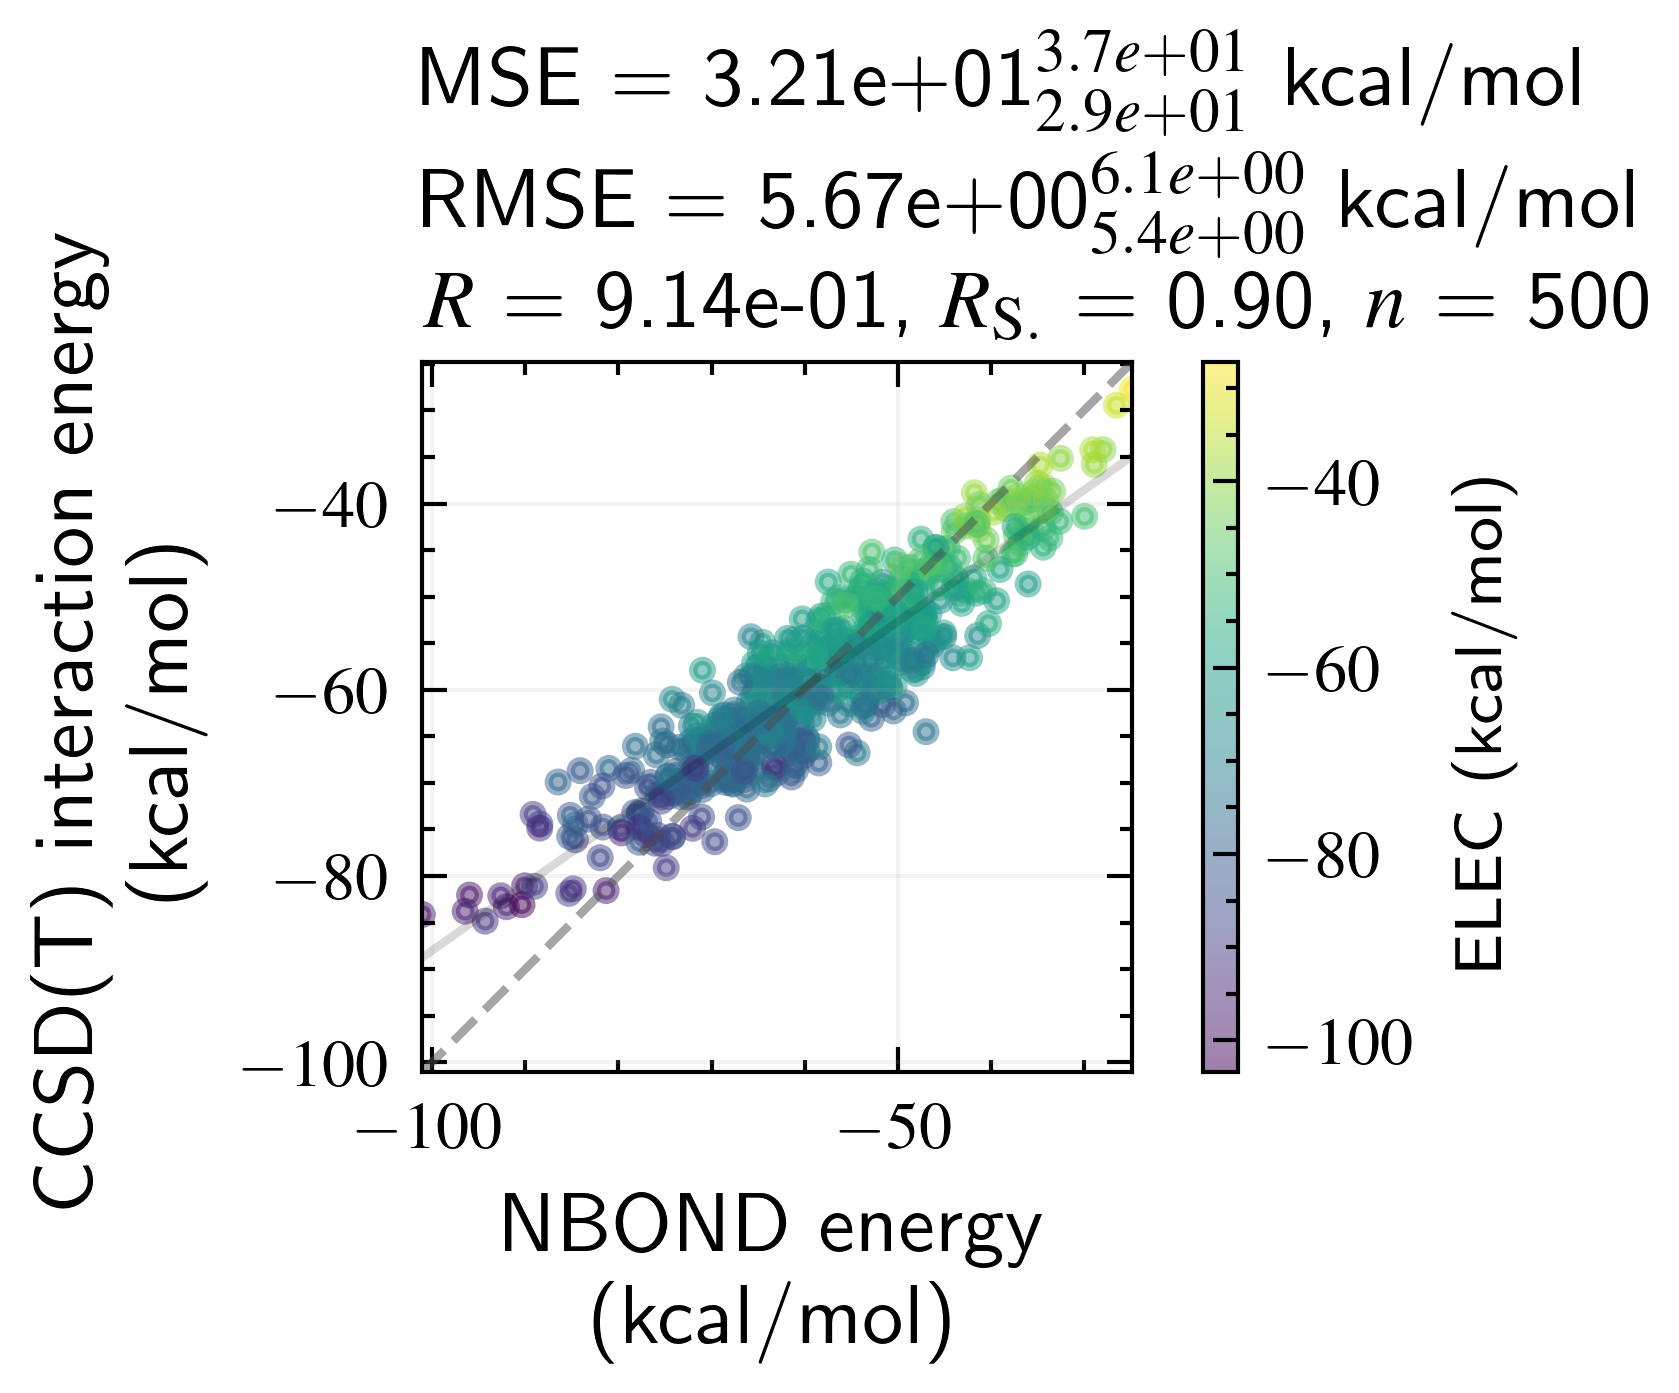

In [34]:
plot_energy_MSE(_c.data, 
                "intE",
                # "first_order_energy",
                "fit_intE", 
                elec="ELEC",
                # xlabel="Target", 
                # ylabel="Fit",
                s=5)


3.082021611252802e-60


(<Axes: xlabel='Target', ylabel='Fit'>,
 {'MSE': 32.102535,
  'RMSE': 5.66591,
  'R': 0.6453573976993843,
  'RS': 0.6369710918843676,
  'n': 500,
  'slope': 0.41667841903629255,
  'intercept': 4.929228284036613})

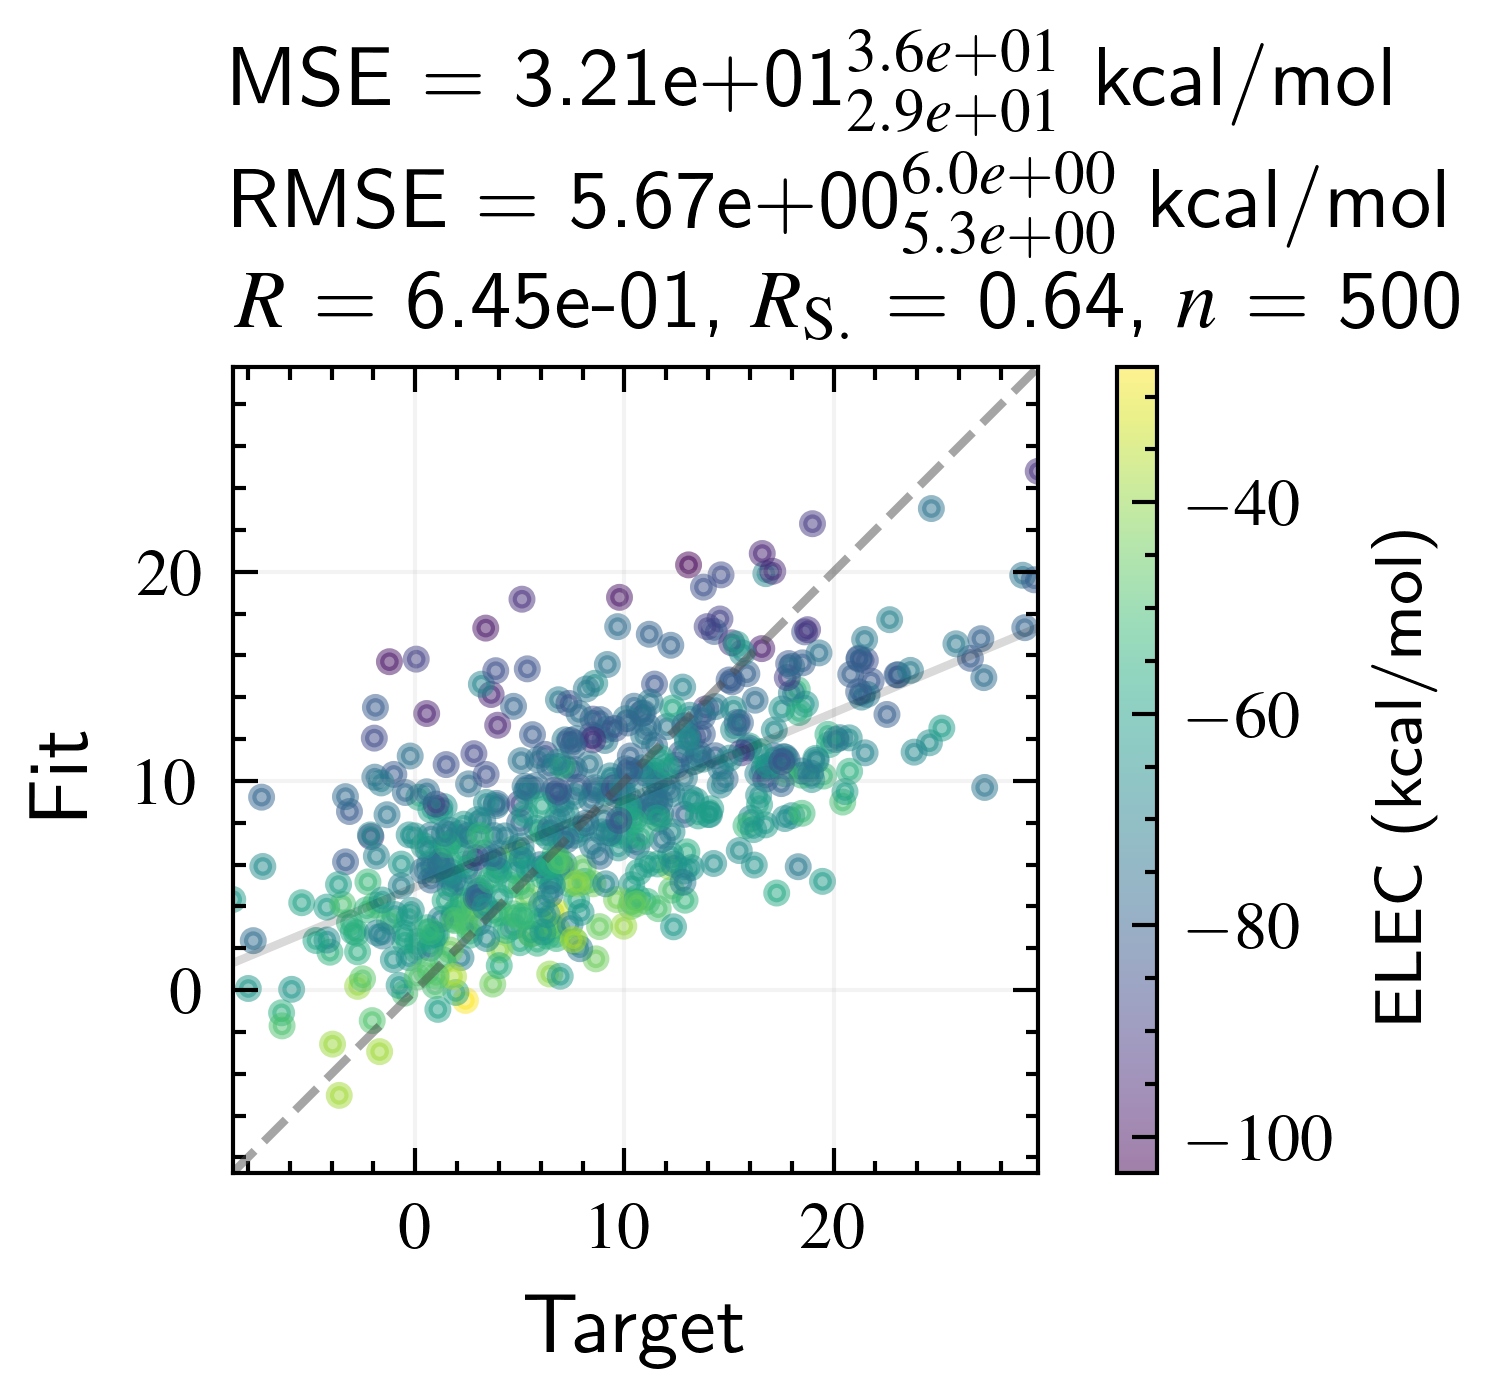

In [35]:
plot_energy_MSE(_c.data, 
                "TARGET", 
                "FIT", 
                elec="ELEC",
                xlabel="Target", 
                ylabel="Fit",
                s=5)


#  Make the bash files for generating reports

In [4]:
# paths = 

In [118]:
# for p in paths:
#     if n_dyna > 1:
#         path = str(p)
#         logkey = "_".join(path[path.find("sim"):].split("/")[:-1])
#         print(logkey, n_dyna)

        
#         pm = papermill_job.format(path=path,
#                     logkey=logkey,
#                     NSAVC=nsavc,
#                     dt=dt)
        
#         with open(f"in_scripts/{logkey}_pm.sh", "w") as f:
#             f.write(pm)
        
        
        

#  FF


In [137]:
?FF

Init signature:
FF(
    data,
    dists,
    func,
    bounds,
    structure,
    nobj=4,
    elec='ELEC',
    intern='Exact',
    intE='intE',
    pairs=False,
)
Docstring:      <no docstring>
File:           ~/Documents/phd/ff_energy/ff_energy/ffe/ff.py
Type:           type
Subclasses:     

In [139]:
structures, dists = next(read_from_pickle(f"water_cluster.pkl"))

In [152]:
# structures
# dists = {_.name.split(".")[0]: _.distances for _ in structures}
# dists

In [154]:
len(dists.keys())

500

In [156]:
from ff_energy.ffe.cli import load_config_maker, charmm_jobs
from ff_energy.ffe.utils import pickle_output
structure = "water_cluster"

# print("No pickled distances/structure information, calculating:")
# CMS = load_config_maker("pbe0dz", structure, "pc")
# jobs = charmm_jobs(CMS)
# dists = {_.name.split(".")[0]: _.distances for _ in jobs[0].structures}
# structures = [_ for _ in jobs[0].structures]

pickle_output((structures, dists), name=f"structures/{structure}")

In [158]:
template_ff = FF(data_.data,
  dists,
  LJ,
  None,
  structures[0],
  )

In [159]:
# dists

In [162]:
pickle_output(template_ff, name=f"ff/template.ff")

In [163]:
template_ff

FF: LJ water_cluster ELEC Exact intE (jax_coloumb: False)